In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
merge_data=pd.read_pickle('merge_regression_data.pkl')
merge_data.head()

,time_id,book.seconds_in_bucket.count,book.wap1.nanmean,book.wap1.nanstd,book.wap1.difference,book.wap2.nanmean,book.wap2.nanstd,book.wap2.difference,book.log_return1.nansum,book.log_return1.realized_volatility,book.log_return2.nansum,book.log_return2.realized_volatility,book.log_return_ask1.nansum,book.log_return_ask1.realized_volatility,book.log_return_ask2.nansum,book.log_return_ask2.realized_volatility,book.log_return_bid1.nansum,book.log_return_bid1.realized_volatility,book.log_return_bid2.nansum,book.log_return_bid2.realized_volatility,book.wap_balance.nanmean,book.wap_balance.nanstd,book.BidAskSpread.nanmax,book.BidAskSpread.nanmean,book.BidAskSpread.difference,book.bid_spread.nanmax,book.bid_spread.nanmean,book.bid_spread.difference,book.ask_spread.nanmax,book.ask_spread.nanmean,book.ask_spread.difference,book.total_volume.nansum,book.total_volume.nanmean,book.total_volume.difference,book.volume_imbalance.nansum,book.volume_imbalance.nanmean,book.volume_imbalance.nanmax,missing_values,book_3to_9.seconds_in_bucket.count,book_3to_9.wap1.nanmean,book_3to_9.wap1.nanstd,book_3to_9.wap1.difference,book_3to_9.wap2.nanmean,book_3to_9.wap2.nanstd,book_3to_9.wap2.difference,book_3to_9.log_return1.nansum,book_3to_9.log_return1.realized_volatility,book_3to_9.log_return2.nansum,book_3to_9.log_return2.realized_volatility,book_3to_9.log_return_ask1.nansum,book_3to_9.log_return_ask1.realized_volatility,book_3to_9.log_return_ask2.nansum,book_3to_9.log_return_ask2.realized_volatility,book_3to_9.log_return_bid1.nansum,book_3to_9.log_return_bid1.realized_volatility,book_3to_9.log_return_bid2.nansum,book_3to_9.log_return_bid2.realized_volatility,book_3to_9.wap_balance.nanmean,book_3to_9.wap_balance.nanstd,book_3to_9.BidAskSpread.nanmax,book_3to_9.BidAskSpread.nanmean,book_3to_9.BidAskSpread.difference,book_3to_9.bid_spread.nanmax,book_3to_9.bid_spread.nanmean,book_3to_9.bid_spread.difference,book_3to_9.ask_spread.nanmax,book_3to_9.ask_spread.nanmean,book_3to_9.ask_spread.difference,book_3to_9.total_volume.nansum,book_3to_9.total_volume.nanmean,book_3to_9.total_volume.difference,book_3to_9.volume_imbalance.nansum,book_3to_9.volume_imbalance.nanmean,book_3to_9.volume_imbalance.nanmax,book_5to_9.seconds_in_bucket.count,book_5to_9.wap1.nanmean,book_5to_9.wap1.nanstd,book_5to_9.wap1.difference,book_5to_9.wap2.nanmean,book_5to_9.wap2.nanstd,book_5to_9.wap2.difference,book_5to_9.log_return1.nansum,book_5to_9.log_return1.realized_volatility,book_5to_9.log_return2.nansum,book_5to_9.log_return2.realized_volatility,book_5to_9.log_return_ask1.nansum,book_5to_9.log_return_ask1.realized_volatility,book_5to_9.log_return_ask2.nansum,book_5to_9.log_return_ask2.realized_volatility,book_5to_9.log_return_bid1.nansum,book_5to_9.log_return_bid1.realized_volatility,book_5to_9.log_return_bid2.nansum,book_5to_9.log_return_bid2.realized_volatility,book_5to_9.wap_balance.nanmean,book_5to_9.wap_balance.nanstd,book_5to_9.BidAskSpread.nanmax,book_5to_9.BidAskSpread.nanmean,book_5to_9.BidAskSpread.difference,book_5to_9.bid_spread.nanmax,book_5to_9.bid_spread.nanmean,book_5to_9.bid_spread.difference,book_5to_9.ask_spread.nanmax,book_5to_9.ask_spread.nanmean,book_5to_9.ask_spread.difference,book_5to_9.total_volume.nansum,book_5to_9.total_volume.nanmean,book_5to_9.total_volume.difference,book_5to_9.volume_imbalance.nansum,book_5to_9.volume_imbalance.nanmean,book_5to_9.volume_imbalance.nanmax,book_7to_9.seconds_in_bucket.count,book_7to_9.wap1.nanmean,book_7to_9.wap1.nanstd,book_7to_9.wap1.difference,book_7to_9.wap2.nanmean,book_7to_9.wap2.nanstd,book_7to_9.wap2.difference,book_7to_9.log_return1.nansum,book_7to_9.log_return1.realized_volatility,book_7to_9.log_return2.nansum,book_7to_9.log_return2.realized_volatility,book_7to_9.log_return_ask1.nansum,book_7to_9.log_return_ask1.realized_volatility,book_7to_9.log_return_ask2.nansum,book_7to_9.log_return_ask2.realized_volatility,book_7to_9.log_return_bid1.nansum,book_7to_9.log_return_bid1.realized_volatility,book_7to_9.log_retur

In [7]:
non_features=["time_id","stock_id","target"]
features=[col for col in merge_data.columns if col not in non_features]
data=merge_data.dropna(subset=["target"])

['book.seconds_in_bucket.count',
 'book.wap1.nanmean',
 'book.wap1.nanstd',
 'book.wap1.difference',
 'book.wap2.nanmean',
 'book.wap2.nanstd',
 'book.wap2.difference',
 'book.log_return1.nansum',
 'book.log_return1.realized_volatility',
 'book.log_return2.nansum',
 'book.log_return2.realized_volatility',
 'book.log_return_ask1.nansum',
 'book.log_return_ask1.realized_volatility',
 'book.log_return_ask2.nansum',
 'book.log_return_ask2.realized_volatility',
 'book.log_return_bid1.nansum',
 'book.log_return_bid1.realized_volatility',
 'book.log_return_bid2.nansum',
 'book.log_return_bid2.realized_volatility',
 'book.wap_balance.nanmean',
 'book.wap_balance.nanstd',
 'book.BidAskSpread.nanmax',
 'book.BidAskSpread.nanmean',
 'book.BidAskSpread.difference',
 'book.bid_spread.nanmax',
 'book.bid_spread.nanmean',
 'book.bid_spread.difference',
 'book.ask_spread.nanmax',
 'book.ask_spread.nanmean',
 'book.ask_spread.difference',
 'book.total_volume.nansum',
 'book.total_volume.nanmean',
 'boo

In [4]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (sMAPE) between true and predicted values.

    Arguments:
    y_true -- Array-like, true values
    y_pred -- Array-like, predicted values

    Returns:
    sMAPE -- Symmetric Mean Absolute Percentage Error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    return 100 * diff

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
results_rf=pd.DataFrame()
feature_importances = {}
for stock_id in tqdm(data.stock_id.unique()):
    stock_data = data[data["stock_id"]==stock_id]
    X = stock_data.drop("target",axis=1)
    X = X.fillna(X.mean())
    y = stock_data["target"]
    stock_feature_importances = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        

        model = RandomForestRegressor(n_estimators=50,random_state=42,n_jobs=-1,max_features="sqrt")
        model.fit(X_train[features], y_train)

        test_pred = model.predict(X_test[features])

        smape_array = smape(y_test, test_pred)

        fold_results = pd.DataFrame({
            'stock_id': X_test["stock_id"],
            "time_id": X_test["time_id"],
            # 'RF_SMAPE': smape_array
            "RF_vol" :test_pred
        })
        results_rf = pd.concat([results_rf, fold_results], ignore_index=True)
        stock_feature_importances.append(model.feature_importances_)

    # Calculate average feature importance for this stock
    avg_feature_importances = np.mean(stock_feature_importances, axis=0)
    feature_importances[stock_id] = avg_feature_importances
    
    

100%|██████████| 112/112 [02:14<00:00,  1.20s/it]


In [8]:
feature_importances_df = pd.DataFrame(feature_importances, index=features).T

# Calculate the overall average feature importance across all stocks
overall_avg_feature_importance = feature_importances_df.mean(axis=0)

# Display the overall average feature importance
print(overall_avg_feature_importance.sort_values(ascending=False))

book_3to_9.log_return1.realized_volatility        0.069335
book_5to_9.log_return1.realized_volatility        0.062377
book.log_return1.realized_volatility              0.048349
book_3to_9.log_return_ask2.realized_volatility    0.039123
book_3to_9.log_return2.realized_volatility        0.032913
                                                    ...   
book_5to_9.wap1.nanmean                           0.001480
book_7to_9.volume_imbalance.nanmax                0.000105
book_5to_9.volume_imbalance.nanmax                0.000036
book_3to_9.volume_imbalance.nanmax                0.000023
book.volume_imbalance.nanmax                      0.000016
Length: 145, dtype: float64


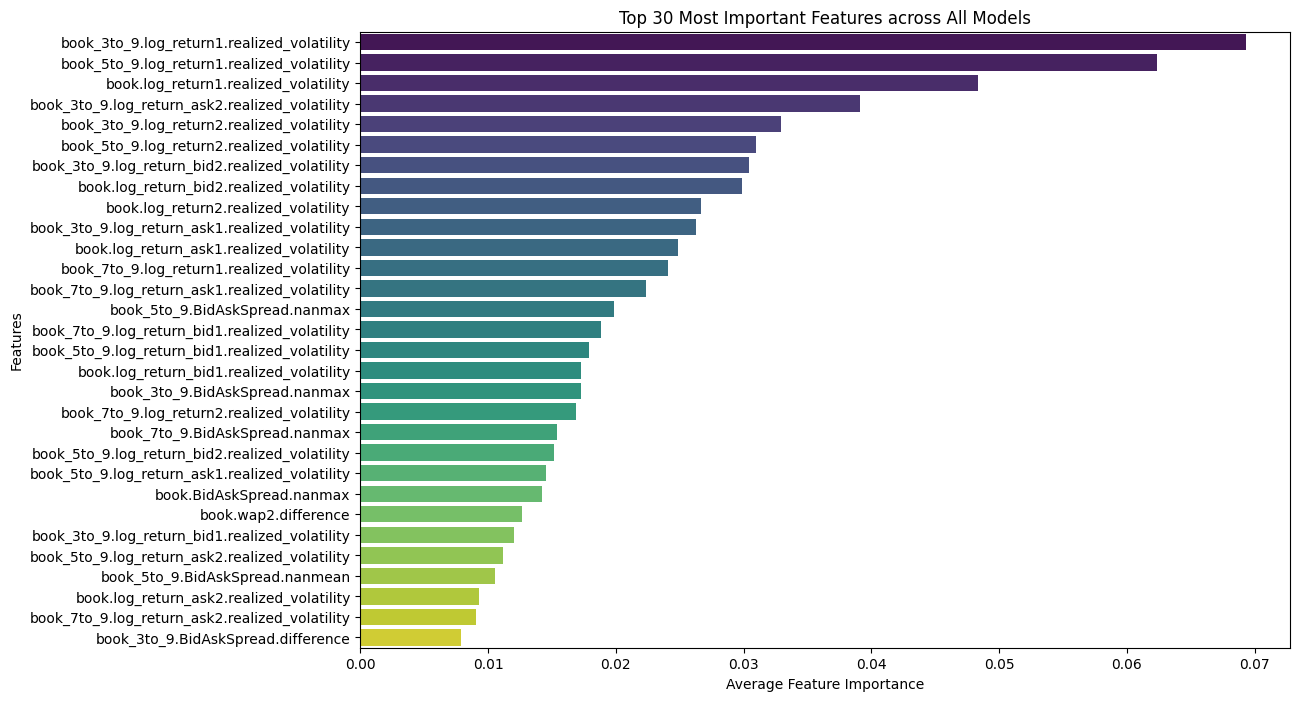

In [10]:
top_30_features = overall_avg_feature_importance.sort_values(ascending=False).head(30)

# Visualize the top 30 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x=top_30_features.values, y=top_30_features.index, palette='viridis')
plt.title('Top 30 Most Important Features across All Models')
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.show()


In [59]:
results_rf.head()

,stock_id,time_id,RF_vol
0,0,5,0.001006
1,0,147,0.000924
2,0,157,0.002186
3,0,207,0.002216
4,0,256,0.000798
...,...,...,...
428849,126,32680,0.001568
428850,126,32686,0.000772
428851,126,32690,0.001677
428852,126,32692,0.001223


In [30]:
import os
model_directory = "random_forest"
os.makedirs(model_directory, exist_ok=True)

In [38]:
import pickle
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
for stock_id in tqdm(data.stock_id.unique()):
    stock_data = data[data["stock_id"]==stock_id]
    X = stock_data.drop("target",axis=1)[features]
    X = X.fillna(X.mean())
    y = stock_data["target"]
    model = RandomForestRegressor(n_estimators=50,random_state=42,n_jobs=-1,max_features="sqrt")
    model.fit(X, y)
    model_filename = os.path.join(model_directory, f'RF_{stock_id}.pkl')
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    

100%|██████████| 112/112 [01:06<00:00,  1.68it/s]


In [60]:
results_rf.mean()

stock_id       62.440271
time_id     16039.047268
RF_vol          0.001202
dtype: float64

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  3.5min
100%|██████████| 112/112 [03:58<00:00,  2.13s/it]
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  85 out of 112 | elapsed:  5.6min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  97 out of 112 | elapsed:  6.0min remaining:   55.6s
[Parallel(n_jobs=-1)]: Done 109 out of 112 | elapsed:  6.5min remaining:   10.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  6.6min finished


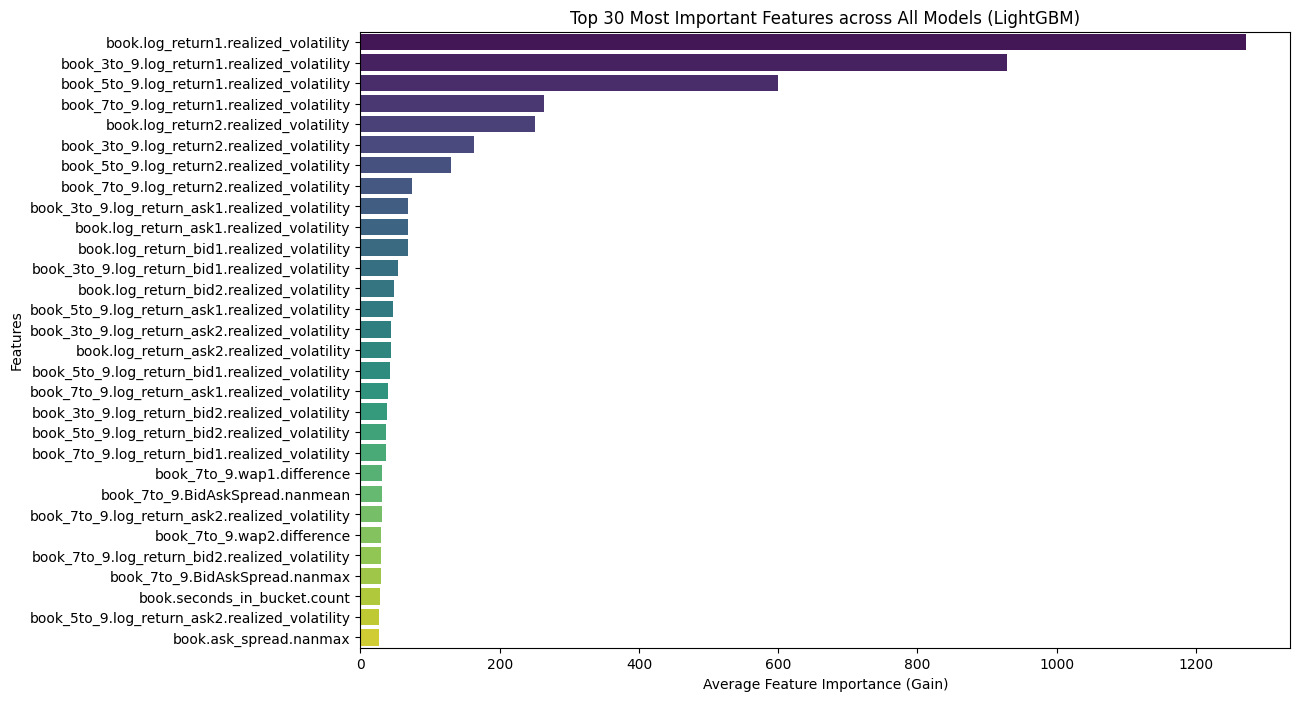

In [16]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a smape function defined elsewhere
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def train_predict(stock_id, data, features, params):
    stock_data = data[data["stock_id"] == stock_id]
    X = stock_data.drop("target", axis=1)
    X = X.fillna(X.mean())
    y = stock_data["target"]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results_lgb = pd.DataFrame()
    feature_importances = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        weight_val = 1 / (np.power(y_train, 2) + 1e-5)
        train_data = lgb.Dataset(X_train[features], label=y_train, weight=weight_val)
        test_data = lgb.Dataset(X_test[features], label=y_test)
        
        model = lgb.train(params, train_data, num_boost_round=1500, valid_sets=[test_data])
        
        test_pred = model.predict(X_test[features])
        
        smape_array = smape(y_test, test_pred)
        
        fold_results = pd.DataFrame({
            'stock_id': X_test["stock_id"],
            "time_id": X_test["time_id"],
            "LGB_vol": test_pred
        })
        results_lgb = pd.concat([results_lgb, fold_results], ignore_index=True)
        
        feature_importances.append(model.feature_importance(importance_type='gain'))

    avg_feature_importances = np.mean(feature_importances, axis=0)
    return results_lgb, avg_feature_importances

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "verbose": -1
}

# Features used for training
features = data.columns.drop(['target', 'stock_id', 'time_id'])  # Adjust according to your data

results = Parallel(n_jobs=-1, verbose=10)(delayed(train_predict)(stock_id, data, features, params) for stock_id in tqdm(data.stock_id.unique()))

# Separate the results and feature importances
results_lgb, feature_importances_list = zip(*results)

# Concatenate the results
results_lgb = pd.concat(results_lgb, ignore_index=True)

# Calculate the overall average feature importance across all stocks
overall_avg_feature_importance = np.mean(feature_importances_list, axis=0)

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': overall_avg_feature_importance
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Select the top 30 most important features
top_30_features = feature_importance_df.head(30)

# Visualize the top 30 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Most Important Features across All Models (LightGBM)')
plt.xlabel('Average Feature Importance (Gain)')
plt.ylabel('Features')
plt.show()

# Optionally, save the feature importances to a CSV file
feature_importance_df.to_csv('lightgbm_feature_importances.csv', index=False)


In [62]:
results_lgb

,stock_id,time_id,LGB_vol
0,0,5,0.000978
1,0,147,0.000723
2,0,157,0.001891
3,0,207,0.002189
4,0,256,0.000825
...,...,...,...
428849,126,32680,0.001252
428850,126,32686,0.000807
428851,126,32690,0.001467
428852,126,32692,0.001216


In [46]:
from joblib import Parallel, delayed
import lightgbm as lgb
def train_predict(stock_id, data, features, params, model_directory="LightGBM"):
    
    os.makedirs(model_directory, exist_ok=True)
    
    stock_data = data[data["stock_id"] == stock_id]
    X = stock_data.drop("target", axis=1)[features]
    X = X.fillna(X.mean())
    y = stock_data["target"]
    
    # Calculate weights for training to handle imbalance or noise in the data
    weight = 1 / (np.power(y, 2) + 1e-5)
    train_data = lgb.Dataset(X, label=y, weight=weight)
    
    # Train the model on the full dataset
    model = lgb.train(params, train_data, num_boost_round=1500)
    
    # Save the model to disk
    model_path = os.path.join(model_directory, f'LGB_{stock_id}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "verbose": -1
}



# Collect unique stock IDs and prepare data features, assuming 'data' and 'features' are defined
_ = Parallel(n_jobs=-1, verbose=10)(delayed(train_predict)(stock_id, data, features, params) for stock_id in tqdm(data.stock_id.unique()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  1.0min
100%|██████████| 112/112 [01:09<00:00,  1.62it/s]
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  85 out of 112 | elapsed:  1.5min remaining:   28.0s
[Parallel(n_jobs=-1)]: Done  97 out of 112 | elapsed:  1.5min remaining:   14.3s
[Parallel(n_jobs=-1)]: Done 109 out of 112 | elapsed:  1.7min remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.7min finished


In [47]:
with open("LightGBM/LGB_1.pkl", 'rb') as file:
    model = pickle.load(file)
    print(len(model.predict(X)))

3829


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

results_lr = pd.DataFrame()
for stock_id in data.stock_id.unique():
    stock_data = data[data["stock_id"]==stock_id]
    X = stock_data.drop("target",axis=1)
    X = X.fillna(X.mean())
    y = stock_data["target"]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)


    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = LinearRegression()
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95))
        ])
        X_train_pca=pipeline.fit_transform(X_train[features])
        X_test_pca=pipeline.transform(X_test[features])
        model.fit(X_train_pca, y_train)


        test_pred = model.predict(X_test_pca)

        smape_array = smape(y_test, test_pred)

        fold_results = pd.DataFrame({
            'stock_id': X_test["stock_id"],
            "time_id": X_test["time_id"],
            # 'LR_SMAPE': smape_array
            "LR_vol": test_pred,
            "original_vol":y_test
        })
        results_lr = pd.concat([results_lr, fold_results], ignore_index=True)




In [16]:
results_lr.mean()

stock_id       62.440271
time_id     16039.047268
LR_SMAPE       29.775580
dtype: float64

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
def train_predict_lr(stock_id, data, features, model_directory="LinearReg"):
    # Ensure the directory exists where models will be saved
    os.makedirs(model_directory, exist_ok=True)

    stock_data = data[data["stock_id"] == stock_id]
    X = stock_data.drop("target", axis=1)[features]
    X = X.fillna(X.mean())
    y = stock_data["target"]

    # Set up the pipeline with PCA and scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('linear_regression', LinearRegression())
    ])

    # Fit the pipeline on the entire dataset
    pipeline.fit(X, y)

    # Save the model to disk
    model_path = os.path.join(model_directory, f'lr_{stock_id}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(pipeline, f)


# Run the model training and saving in parallel
_ = Parallel(n_jobs=-1, verbose=10)(delayed(train_predict_lr)(stock_id, data, features) for stock_id in tqdm(data.stock_id.unique()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  

NameError: name 'os' is not defined

In [49]:
with open("LinearReg/lr_1.pkl", 'rb') as file:
    model = pickle.load(file)
    print(len(model.predict(X)))

3829


In [66]:
performance_table = results_lr.merge(results_rf, on=['stock_id', 'time_id'])
performance_table = performance_table.merge(results_lgb, on=['stock_id', 'time_id'])
vol_table=performance_table.copy()
vol_table

,stock_id,time_id,LR_vol,original_vol,RF_vol,LGB_vol
0,0,5,0.001112,0.001246,0.001006,0.000978
1,0,147,0.000953,0.000282,0.000924,0.000723
2,0,157,0.002078,0.001448,0.002186,0.001891
3,0,207,0.002252,0.002504,0.002216,0.002189
4,0,256,0.000920,0.001740,0.000798,0.000825
...,...,...,...,...,...,...
428849,126,32680,0.001388,0.000487,0.001568,0.001252
428850,126,32686,0.000661,0.000934,0.000772,0.000807
428851,126,32690,0.001414,0.000475,0.001677,0.001467
428852,126,32692,0.001325,0.000792,0.001223,0.001216


In [67]:
vol_table.sort_values(["stock_id","time_id"])

,stock_id,time_id,LR_vol,original_vol,RF_vol,LGB_vol
0,0,5,0.001112,0.001246,0.001006,0.000978
3063,0,11,0.000546,0.000779,0.000446,0.000458
1532,0,16,0.001039,0.000323,0.000741,0.000867
2298,0,31,0.000703,0.000931,0.000754,0.000564
3064,0,62,0.000465,0.001035,0.000603,0.000535
...,...,...,...,...,...,...
427320,126,32751,0.001155,0.001374,0.001038,0.001050
427321,126,32753,0.000956,0.002307,0.001136,0.000783
425790,126,32758,0.001133,0.001096,0.001067,0.000846
427322,126,32763,0.001157,0.000654,0.001117,0.001100


In [37]:
vol_table.to_csv("vol_table.csv")

In [38]:
performance_table.mean()

stock_id        62.440271
time_id      16039.047268
LR_SMAPE        29.775580
RF_SMAPE        29.315779
LGB_SMAPE       29.355608
dtype: float64

In [ ]:
time_id_performance=performance_table.groupby("time_id").agg(aggregate_dict)

<Axes: >

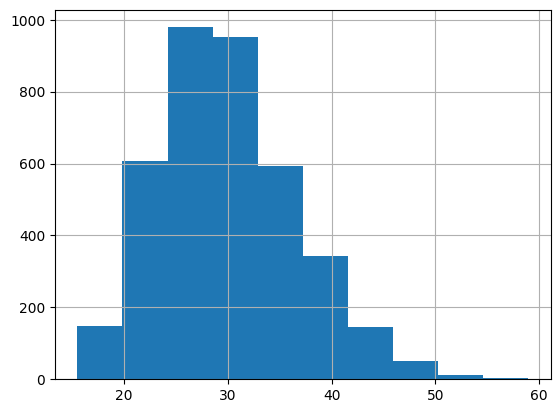

In [ ]:
time_id_performance.mean(axis=1).sort_values().hist()

<Axes: >

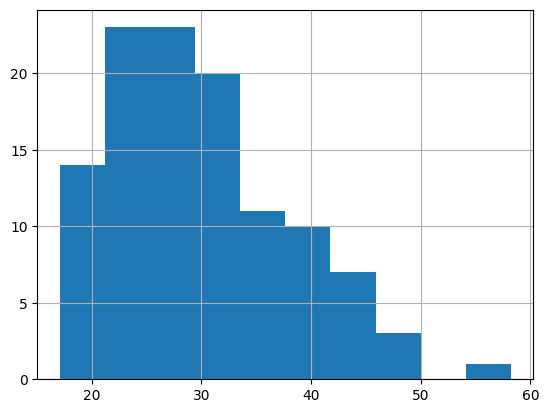

In [ ]:
stock_id_performance.mean(axis=1).sort_values().hist()

In [ ]:
pd.read_csv("performance_table.csv").groupby(["stock_id"])["LR_SMAPE"].mean()

stock_id
0      41.056745
1      26.496137
2      23.230376
3      29.081545
4      36.969094
         ...    
122    25.726124
123    22.805568
124    17.383616
125    29.699115
126    32.407487
Name: LR_SMAPE, Length: 112, dtype: float64